In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

import os 
from tqdm import tqdm
import warnings `
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset_final.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission_final.csv')

In [3]:
train = train.drop(['매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis=1)

In [4]:
train.shape, test.shape, submission.shape

((23009, 30), (4244, 29), (4244, 2))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23009 entries, 0 to 23008
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEQ         23009 non-null  object 
 1   접수일         23009 non-null  object 
 2   접수시각        3113 non-null   object 
 3   장기서비스여부     23009 non-null  int64  
 4   최초서비스일      23009 non-null  object 
 5   전체회차        23009 non-null  int64  
 6   현재회차        23009 non-null  int64  
 7   서비스일자       23009 non-null  object 
 8   서비스시작시간     23009 non-null  object 
 9   서비스종료시간     23009 non-null  object 
 10  기존고객여부      23009 non-null  int64  
 11  결재형태        23009 non-null  object 
 12  서비스주소       23009 non-null  object 
 13  주거형태        23009 non-null  object 
 14  평수          13856 non-null  object 
 15  고객가입일       23009 non-null  object 
 16  반려동물        20234 non-null  object 
 17  부재중여부       13856 non-null  float64
 18  우선청소        10979 non-null  object 
 19  쿠폰사용여부      23009 non-nul

In [6]:
submission.head()

,SEQ,pred
0,T54370,0.5
1,T47892,0.5
2,T56637,0.5
3,T45487,0.5
4,T41995,0.5


## 기본 전처리 및 feature 생성

In [7]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일']).dt.year

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S')
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S')
train['서비스시작시간2'] = train['서비스시작시간'].dt.hour
train['서비스종료시간2'] = train['서비스종료시간'].dt.hour

train['서비스소요시간'] = train['서비스종료시간'] - train['서비스시작시간']
train['회차사용비율'] = train['현재회차'] / train['전체회차']

# 기간 관련 피처
#train['접수일기준_고객가입기간'] = train['접수일'] - train['고객가입일']
train['접수후최초서비스걸린시일'] = train['최초서비스일'] - train['접수일']
train['접수후서비스걸린시일'] = train['서비스일자'] - train['접수일']
train['최초서비스_서비스_시일'] = train['서비스일자'] - train['최초서비스일']

In [8]:
# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
#test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S')
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S')
test['서비스시작시간2'] = test['서비스시작시간'].dt.hour
test['서비스종료시간2'] = test['서비스종료시간'].dt.hour

test['서비스소요시간'] = test['서비스종료시간'] - test['서비스시작시간']
test['회차사용비율'] = test['현재회차'] / test['전체회차']

# 기간 관련 피처
#test['접수일기준_고객가입기간'] = test['접수일'] - test['고객가입일']
test['접수후최초서비스걸린시일'] = test['최초서비스일'] - test['접수일']
test['접수후서비스걸린시일'] = test['서비스일자'] - test['접수일']
test['최초서비스_서비스_시일'] = test['서비스일자'] - test['최초서비스일']

In [9]:
# timedelta 형식 feature -> int형식으로
#train['접수일기준_고객가입기간'] = train['접수일기준_고객가입기간'].dt.days.astype('int16')
train['접수후최초서비스걸린시일'] = train['접수후최초서비스걸린시일'].dt.days.astype('int16')
train['접수후서비스걸린시일'] = train['접수후서비스걸린시일'].dt.days.astype('int16')
train['최초서비스_서비스_시일'] = train['최초서비스_서비스_시일'].dt.days.astype('int16')
train['서비스소요시간'] = train['서비스소요시간'].dt.seconds.astype('int32') // 3600

#test['접수일기준_고객가입기간'] = test['접수일기준_고객가입기간'].dt.days.astype('int16')
test['접수후최초서비스걸린시일'] = test['접수후최초서비스걸린시일'].dt.days.astype('int16')
test['접수후서비스걸린시일'] = test['접수후서비스걸린시일'].dt.days.astype('int16')
test['최초서비스_서비스_시일'] = test['최초서비스_서비스_시일'].dt.days.astype('int16')
test['서비스소요시간'] = test['서비스소요시간'].dt.seconds.astype('int32') // 3600

In [10]:
# 시간 추가 여부
train['시간추가여부'] = train['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)
test['시간추가여부'] = test['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)

In [11]:
# sin, cos encoding 월/주/일까지 적용
# train['sin_서비스시작시간'] = np.sin(2*np.pi*train['서비스시작시간2']/24)
# train['cos_서비스시작시간'] = np.cos(2*np.pi*train['서비스시작시간2']/24)
# train['sin_서비스종료시간'] = np.sin(2*np.pi*train['서비스종료시간2']/24)
# train['cos_서비스종료시간'] = np.cos(2*np.pi*train['서비스종료시간2']/24)

# test['sin_서비스시작시간'] = np.sin(2*np.pi*test['서비스시작시간2']/24)
# test['cos_서비스시작시간'] = np.cos(2*np.pi*test['서비스시작시간2']/24)
# test['sin_서비스종료시간'] = np.sin(2*np.pi*test['서비스종료시간2']/24)
# test['cos_서비스종료시간'] = np.cos(2*np.pi*test['서비스종료시간2']/24)

In [12]:
# 매니저 나이
train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x)

In [13]:
# train['회차대비서비스일']=train.최초서비스_서비스_시일*train.회차사용비율
# test['회차대비서비스일']=test.최초서비스_서비스_시일*test.회차사용비율

In [14]:
#고객 열만~ 
na_sum=[]
for i in range (0,train.shape[0],1):
    na_all=train.iloc[i:i+1,3:20].isna().sum().sum()
    na_sum.append(na_all)

In [15]:
na_sum_te=[]
for i in range (0,test.shape[0],1):
    na_all=test.iloc[i:i+1,3:20].isna().sum().sum()
    na_sum_te.append(na_all)

In [16]:
na_df=pd.DataFrame(na_sum)
na_df.columns=['na값']

In [17]:
na_df_te=pd.DataFrame(na_sum_te)
na_df_te.columns=['na값']

In [18]:
train=pd.concat([train,na_df],axis=1)
test=pd.concat([test,na_df_te],axis=1)

In [19]:
train

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,고객가입일,반려동물,부재중여부,우선청소,쿠폰사용여부,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부,서비스시작시간2,서비스종료시간2,서비스소요시간,회차사용비율,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,매니저나이,na값
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,1900-01-01 09:00:00,1900-01-01 13:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-04-22,NaN,NaN,NaN,0,1956,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0,9,13,4,1.00,6,20,14,0,65,4
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,1900-01-01 10:00:00,1900-01-01 16:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-05-21,없음,NaN,NaN,0,1976,0,안드로이드,대중교통,천안/아산,1.0,1.0,1,0,0,10,16,6,0.75,3,39,36,0,45,3
2,T23790,2020-11-18,NaN,1,2020-11-23,10,6,2020-12-11,1900-01-01 09:00:00,1900-01-01 13:00:00,1,신용카드,충남 천안시,일반주택,40평대이상,2020-10-14,없음,0.0,NaN,0,1970,0,안드로이드,대중교통,천안/아산,0.0,0.0,0,0,0,9,13,4,0.60,5,23,18,0,51,1
3,T18740,2020-11-09,NaN,1,2020-11-09,4,4,2020-11-30,1900-01-01 09:00:00,1900-01-01 14:00:00,1,무통장입금,서울 강서구,일반주택,30평대,2020-02-06,없음,0.0,방,0,1956,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0,9,14,5,1.00,0,21,21,1,65,0
4,T08451,2020-02-25,NaN,1,2020-03-31,2,2,2020-04-07,1900-01-01 09:00:00,1900-01-01 13:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-09-20,NaN,NaN,NaN,0,1966,0,안드로이드,대중교통,천안/아산,0.0,0.0,1,0,1,9,13,4,1.00,35,42,7,0,55,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23004,T17071,2021-01-05,11:11:15,1,2021-01-06,4,1,2021-01-06,1900-01-01 16:00:00,1900-01-01 18:00:00,1,신용카드,강원 원주시,오피스텔/원룸,20평대,2020-11-25,고양이,1.0,거실,0,1970,0,안드로이드,자차,천안/아산,0.0,0.0,1,0,0,16,18,2,0.25,1,1,0,0,51,0
23005,T01336,2020-02-03,NaN,1,2020-03-02,10,9,2020-06-15,1900-01-01 14:00:00,1900-01-01 18:00:00,1,신용카드,충남 아산시,일반주택,NaN,2019-06-10,없음,NaN,NaN,1,1969,0,안드로이드,대중교통,천안/아산,0.0,0.0,1,0,1,14,18,4,0.90,28,133,105,0,52,3
23006,T00544,2021-04-30,21:48:21,1,2021-05-20,4,3,2021-06-16,1900-01-01 09:00:00,1900-01-01 13:00:00,1,신용카드,강원 원주시,일반주택,30평대,2021-01-26,없음,1.0,NaN,0,1971,0,안드로이드,대중교통,천안/아산,0.0,0.0,1,0,0,9,13,4,0.75,20,47,27,0,50,1
23007,T19297,2019-07-08,NaN,1,2019-07-10,4,3,2019-07-24,1900-01-01 14:00:00,1900-01-01 18:00:00,1,신용카드,충남 아산시,일반주택,NaN,2019-07-06,NaN,NaN,NaN,0,1967,0,안드로이드,자차,천안/아산,1.0,1.0,1,0,0,14,18,4,0.75,2,16,14,0,54,4


## 데이터 셋 세팅

In [20]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저성별', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '매칭성공여부', '서비스시작시간2', '서비스종료시간2', '서비스소요시간', '회차사용비율', '접수후최초서비스걸린시일',
       '접수후서비스걸린시일', '최초서비스_서비스_시일', '시간추가여부', '매니저나이', 'na값'],
      dtype='object')

In [21]:
features = ['장기서비스여부', '전체회차', '현재회차', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', 
            '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 
            'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스시작시간2', 
            '서비스종료시간2', '서비스소요시간', '회차사용비율', '접수후최초서비스걸린시일', '접수후서비스걸린시일', 
            '최초서비스_서비스_시일', '시간추가여부', '매니저나이','na값']

In [22]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

## 결측치 처리

In [23]:
ftr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23009 entries, 0 to 23008
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   장기서비스여부       23009 non-null  int64  
 1   전체회차          23009 non-null  int64  
 2   현재회차          23009 non-null  int64  
 3   기존고객여부        23009 non-null  int64  
 4   결재형태          23009 non-null  object 
 5   서비스주소         23009 non-null  object 
 6   주거형태          23009 non-null  object 
 7   평수            13856 non-null  object 
 8   반려동물          20234 non-null  object 
 9   부재중여부         13856 non-null  float64
 10  우선청소          10979 non-null  object 
 11  쿠폰사용여부        23009 non-null  int64  
 12  매니저사용휴대폰      20210 non-null  object 
 13  매니저이동방법       22759 non-null  object 
 14  근무가능지역        23009 non-null  object 
 15  CS교육이수여부      20210 non-null  float64
 16  청소교육이수여부      20210 non-null  float64
 17  부재중서비스가능여부    23009 non-null  int64  
 18  추천인여부         23009 non-nu

In [24]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [25]:
# # 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# # 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# # 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# # CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# # 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

# imputer_col = ['반려동물', '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

# for col in imputer_col:
#     ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
#     ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [26]:
# train, test셋의 구성이 다른 피처 처리 - 결제형태, 서비스주소
ftr['서비스주소'] = ftr.서비스주소.str[:2]
ftr['결재형태'] = ftr.결재형태.replace('미수', np.NaN) # or 드랍 
                               
ftr_te['서비스주소'] = ftr_te.서비스주소.str[:2]
ftr_te['결재형태'] = ftr_te.결재형태.replace('미수', np.NaN) # or 드랍    

In [27]:
# 한글로 구성되어 있는 피처 Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['주거형태', '평수', '우선청소', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', '서비스주소', '결재형태','CS교육이수여부', '청소교육이수여부']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [28]:
ftr['평수']=ftr.평수.replace(4,np.NaN)
ftr_te['평수']=ftr_te.평수.replace(4,np.NaN)

In [29]:
ftr['우선청소']=ftr.우선청소.replace(5,np.NaN)
ftr_te['우선청소']=ftr_te.우선청소.replace(5,np.NaN)

In [30]:
#여기까지

# ftr['매니저사용휴대폰']=ftr.매니저사용휴대폰.replace(3,np.NaN)

# ftr['매니저이동방법']=ftr.매니저이동방법.replace(2,np.NaN)

# ftr['CS교육이수여부']=ftr.CS교육이수여부.replace(2,np.NaN)

# ftr['청소교육이수여부']=ftr.청소교육이수여부.replace(2,np.NaN)

#### 반려동물

In [31]:
ftr['반려동물_고양이'] = 0
ftr['반려동물_개'] = 0
ftr['반려동물_기타'] = 0
ftr['반려동물_없음'] = 0

ftr_te['반려동물_고양이'] = 0
ftr_te['반려동물_개'] = 0
ftr_te['반려동물_기타'] = 0
ftr_te['반려동물_없음'] = 0

In [32]:
for i in range(ftr.shape[0]):
    # 한가지 종류 키우는 집
    if ftr['반려동물'][i] == '개':
        ftr['반려동물_개'][i] += 1
    elif ftr['반려동물'][i] == '고양이':
        ftr['반려동물_고양이'][i] += 1
    elif ftr['반려동물'][i] == '기타':
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '없음':
        ftr['반려동물_없음'][i] += 1
    
    # 두가지 종류 키우는 집
    elif ftr['반려동물'][i] == '개,고양이':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
    elif ftr['반려동물'][i] == '고양이,개':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
    elif ftr['반려동물'][i] == '고양이,기타':
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '개,기타':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_기타'][i] += 1
        
    # 세가지 종류 키우는 집
    elif ftr['반려동물'][i] == '개,기타,고양이':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '개,고양이,기타':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '고양이,기타,개':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
    elif ftr['반려동물'][i] == '고양이,개,기타':
        ftr['반려동물_개'][i] += 1
        ftr['반려동물_고양이'][i] += 1
        ftr['반려동물_기타'][i] += 1
        
    else:
        continue

In [33]:
for i in range(ftr_te.shape[0]):
    # 한가지 종류 키우는 집
    if ftr_te['반려동물'][i] == '개':
        ftr_te['반려동물_개'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이':
        ftr_te['반려동물_고양이'][i] += 1
    elif ftr_te['반려동물'][i] == '기타':
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '없음':
        ftr_te['반려동물_없음'][i] += 1
    
    # 두가지 종류 키우는 집
    elif ftr_te['반려동물'][i] == '개,고양이':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,개':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,기타':
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '개,기타':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
        
    # 세가지 종류 키우는 집
    elif ftr_te['반려동물'][i] == '개,기타,고양이':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '개,고양이,기타':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,기타,개':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
    elif ftr_te['반려동물'][i] == '고양이,개,기타':
        ftr_te['반려동물_개'][i] += 1
        ftr_te['반려동물_고양이'][i] += 1
        ftr_te['반려동물_기타'][i] += 1
        
    else:
        continue

In [34]:
ftr = ftr.drop('반려동물', axis=1)
ftr_te = ftr_te.drop('반려동물', axis=1)

In [35]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '부재중여부', '우선청소', 
                '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', 
                '부재중서비스가능여부', '추천인여부', '시간추가여부', '반려동물_고양이', '반려동물_개', '반려동물_기타', 
                '반려동물_없음']

In [36]:
cat_lst = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 28, 29, 30, 31]

In [37]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [38]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

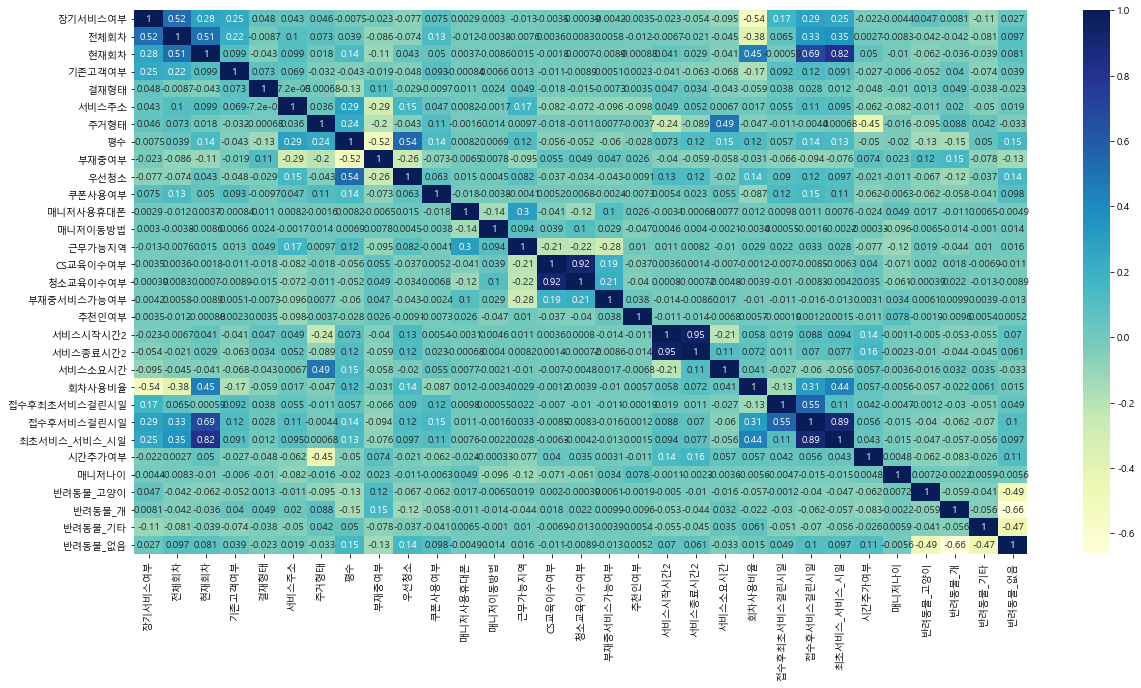

In [68]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 스케일링

### Min-max

In [39]:
num_features = list(set(ftr.columns) - set(cat_features))

In [40]:
num_features

['매니저나이',
 '최초서비스_서비스_시일',
 '접수후최초서비스걸린시일',
 '서비스종료시간2',
 '서비스시작시간2',
 '현재회차',
 '전체회차',
 '서비스소요시간',
 'na값',
 '회차사용비율',
 '접수후서비스걸린시일']

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

## 샘플링

### over sampling

In [42]:
from imblearn.over_sampling import SMOTE

In [74]:
# SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(ftr_imputed, target)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', ftr_imputed.shape, target.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (23009, 30) (23009,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (41622, 30) (41622,)
SMOTE 적용 후 레이블 값 분포: 
 0    20811
1    20811
Name: 매칭성공여부, dtype: int64


In [79]:
ftr_imputed = X_train_over
target = y_train_over

In [632]:
# 문제는 특이 치에있을 수 있습니다. 앞서 언급했듯이 ADASYN은 밀도가 낮은 밀도 데이터에 중점을 둡니다. 
# 종종 저밀도 데이터는 특이 치입니다. 그런 다음 ADASYN 접근 방식은 피쳐 공간의 이러한 영역에 너무 많은주의를 기울여 
# 모델 성능을 저하시킬 수 있습니다. ADASYN을 사용하기 전에 이상 값을 제거하는 것이 좋습니다.
from imblearn.over_sampling import *
X_samp, y_samp = ADASYN(random_state=0, sampling_strategy='minority').fit_sample(ftr_imputed, target)

In [633]:
X_samp.shape, y_samp.shape

((41825, 32), (41825,))

In [634]:
ftr_imputed = X_samp
target = y_samp

특성

In [44]:
train['고객특성']=train['서비스주소'].astype('str') + '_' + train['주거형태'].astype('str')+ '_' + train['평수'].astype('str')+ '_' + train['결재형태'].astype('str')
test['고객특성']=test['서비스주소'].astype('str') + '_' + test['주거형태'].astype('str')+ '_' + test['평수'].astype('str')+ '_' + test['결재형태'].astype('str')

train['매니저특성']=train['매니저나이'].astype('str') + '_' + train['매니저사용휴대폰'].astype('str')+ '_' + train['매니저이동방법'].astype('str')+ '_' + train['근무가능지역'].astype('str')
test['매니저특성']=test['매니저나이'].astype('str') + '_' +test['매니저사용휴대폰'].astype('str')+ '_' + test['매니저이동방법'].astype('str')+ '_' + test['근무가능지역'].astype('str')

fasttext

In [45]:
import random

train_data = list(train['고객특성'].unique())
test_data = list(test['고객특성'].unique())

In [46]:
from gensim.models.fasttext import FastText

In [47]:
model = FastText(sentences=train_data, size=30, window=5, min_count=1, sg=1)
# 길면 size올리기

In [48]:
model.train(sentences=train_data, epochs=5, total_examples=model.corpus_count, 
            total_words=model.corpus_total_words)

In [49]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 7085.34it/s]


In [50]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 3874.21it/s]


In [51]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.columns = train_mean_vector.columns.astype(str) + "_고객특성"

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.columns = test_mean_vector.columns.astype(str) + "_고객특성"

In [52]:
train_mean_vector = pd.DataFrame(train_mean_vector)
test_mean_vector = pd.DataFrame(test_mean_vector)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [53]:
train_data.columns = ['고객특성']
test_data.columns = ['고객특성']

ft_train_2 = pd.concat([train_data, train_mean_vector], axis=1)
ft_test_2 = pd.concat([test_data, test_mean_vector], axis=1)

In [54]:
import random

train_data = list(train['매니저특성'].unique())
test_data = list(test['매니저특성'].unique())

In [55]:
from gensim.models.fasttext import FastText

In [56]:
model = FastText(sentences=train_data, size=30, window=5, min_count=1, sg=1)
# 길면 size올리기

In [57]:
model.train(sentences=train_data, epochs=5, total_examples=model.corpus_count, 
            total_words=model.corpus_total_words)

In [58]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 9797.91it/s]


In [59]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 12552.81it/s]


In [60]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.columns = train_mean_vector.columns.astype(str) + "_매니저특성"

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.columns = test_mean_vector.columns.astype(str) + "_매니저특성"

In [61]:
train_mean_vector = pd.DataFrame(train_mean_vector)
test_mean_vector = pd.DataFrame(test_mean_vector)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [62]:
train_data.columns = ['매니저특성']
test_data.columns = ['매니저특성']

ft_train_1 = pd.concat([train_data, train_mean_vector], axis=1)
ft_test_1 = pd.concat([test_data, test_mean_vector], axis=1)

In [63]:
train = train.merge(ft_train_1, on='매니저특성', how='left')
test = test.merge(ft_test_1, on='매니저특성', how='left')

In [64]:
train = train.merge(ft_train_2, on='고객특성', how='left')
test = test.merge(ft_test_2, on='고객특성', how='left')

In [65]:
ftr_imputed=pd.concat([ftr_imputed,train.iloc[:,-60:]],axis=1)
ftr_te_imputed=pd.concat([ftr_te_imputed,test.iloc[:,-60:]],axis=1)

## 모델링

In [66]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [67]:
kf = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)

In [68]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '부재중여부', '우선청소', 
                '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', 
                '부재중서비스가능여부', '추천인여부', '시간추가여부', '반려동물_고양이', '반려동물_개', '반려동물_기타', 
                '반려동물_없음']

In [69]:
ftr_imputed.shape, target.shape, ftr_te_imputed.shape

((23009, 92), (23009,), (4244, 92))

### Catboost

In [70]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [71]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [72]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [73]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import random
from optuna.samplers import TPESampler
import multiprocessing
import catboost as cat
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.utils import resample
from catboost import Pool
import sklearn.metrics

In [698]:
n_trials = int(20)
SEED = 123

In [699]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(SEED)

In [700]:
X = np.array(ftr_imputed)
y = np.array(target)

In [701]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=int(SEED), shuffle=True)
    train_pool = Pool(train_x, train_y)
    test_pool = Pool(test_x, test_y)
    
    # Parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 1000, 20000),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.01),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }
    # Learning
    model = cat.CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        l2_leaf_reg=50,
        random_seed=SEED,
        border_count=64,
        class_weights=class_weights,
        **params
    )        
    model.fit(train_pool)
    # Predict
    preds = model.predict_proba(test_pool)[:, 1]
    pred_labels = np.rint(preds)
    y_pred_boot = resample(pred_labels, n_samples = len(train_y))
    # Evaluation
    ROC_AUC_Score = roc_auc_score(train_y, y_pred_boot)
    print('ROC AUC Score of CatBoost =', ROC_AUC_Score)
    return ROC_AUC_Score

In [702]:
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials)

[I 2021-11-17 23:40:56,418] A new study created in memory with name: no-name-95a8234e-3f60-4a24-be93-45c9ffa4c027
[W 2021-11-17 23:40:56,421] Trial 0 failed because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [41825, 23009]')
Traceback (most recent call last):
  File "C:\Users\82103\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_13516/2065865540.py", line 2, in objective
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=int(SEED), shuffle=True)
  File "C:\Users\82103\anaconda3\lib\site-packages\sklearn\model_selection\_split.py", line 2419, in train_test_split
    arrays = indexable(*arrays)
  File "C:\Users\82103\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 370, in indexable
    check_consistent_length(*result)
  File "C:\Users\82103\anaconda3\lib\

ValueError: Found input variables with inconsistent numbers of samples: [41825, 23009]

In [74]:
cb = CatBoostClassifier(iterations=2000, learning_rate=0.01, eval_metric='Logloss', class_weights=class_weights,
                        silent=True, loss_function='Logloss')

In [75]:
cb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict_proba(val_x, ntree_end=best)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = cb.predict_proba(ftr_te_imputed, ntree_end=best)[:, 1] / 15
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

0:	learn: 0.6920940	test: 0.6922196	best: 0.6922196 (0)	total: 275ms	remaining: 9m 8s
1999:	learn: 0.2495251	test: 0.3553338	best: 0.3553338 (1999)	total: 3m 6s	remaining: 0us

bestTest = 0.35533376
bestIteration = 1999

FOLD ROC-AUC = 0.9332922299149524
0:	learn: 0.6915153	test: 0.6916719	best: 0.6916719 (0)	total: 46.2ms	remaining: 1m 32s
1999:	learn: 0.2489892	test: 0.3792057	best: 0.3792057 (1999)	total: 1m 38s	remaining: 0us

bestTest = 0.3792057472
bestIteration = 1999

FOLD ROC-AUC = 0.9187104698299402

CatBoostClassifier ROC_AUC_score = 0.9260013498724463


In [76]:
submission['pred'] = (cb_pred)

In [80]:
submission=submission.set_index('SEQ')

In [82]:
submission.to_csv('submission/1118_seong_1.csv')

In [644]:
submission

,pred
SEQ,
T54370,0.000287
T47892,0.217920
T56637,0.152962
T45487,0.001481
T41995,0.092918
...,...
T31589,0.049777
T36236,0.065678
T34729,0.333952


Learning rate set to 0.039306
0:	learn: 0.6579312	total: 60.6ms	remaining: 1m
1:	learn: 0.6263714	total: 71.9ms	remaining: 35.9s
2:	learn: 0.5924883	total: 82.9ms	remaining: 27.5s
3:	learn: 0.5666049	total: 94ms	remaining: 23.4s
4:	learn: 0.5421091	total: 105ms	remaining: 20.9s
5:	learn: 0.5209382	total: 116ms	remaining: 19.2s
6:	learn: 0.5017838	total: 127ms	remaining: 18s
7:	learn: 0.4838940	total: 137ms	remaining: 17s
8:	learn: 0.4683256	total: 148ms	remaining: 16.3s
9:	learn: 0.4526380	total: 159ms	remaining: 15.8s
10:	learn: 0.4398909	total: 170ms	remaining: 15.3s
11:	learn: 0.4281199	total: 182ms	remaining: 15s
12:	learn: 0.4174644	total: 192ms	remaining: 14.6s
13:	learn: 0.4077995	total: 203ms	remaining: 14.3s
14:	learn: 0.3991830	total: 213ms	remaining: 14s
15:	learn: 0.3906808	total: 226ms	remaining: 13.9s
16:	learn: 0.3834512	total: 238ms	remaining: 13.8s
17:	learn: 0.3761274	total: 251ms	remaining: 13.7s
18:	learn: 0.3688625	total: 263ms	remaining: 13.6s
19:	learn: 0.3636572

164:	learn: 0.2422395	total: 1.97s	remaining: 9.98s
165:	learn: 0.2420673	total: 1.99s	remaining: 9.97s
166:	learn: 0.2419472	total: 2s	remaining: 9.96s
167:	learn: 0.2417904	total: 2.01s	remaining: 9.96s
168:	learn: 0.2415490	total: 2.02s	remaining: 9.94s
169:	learn: 0.2413610	total: 2.03s	remaining: 9.93s
170:	learn: 0.2409737	total: 2.05s	remaining: 9.92s
171:	learn: 0.2407360	total: 2.06s	remaining: 9.92s
172:	learn: 0.2405213	total: 2.07s	remaining: 9.91s
173:	learn: 0.2403622	total: 2.08s	remaining: 9.9s
174:	learn: 0.2400695	total: 2.1s	remaining: 9.89s
175:	learn: 0.2398694	total: 2.11s	remaining: 9.88s
176:	learn: 0.2397300	total: 2.12s	remaining: 9.87s
177:	learn: 0.2394550	total: 2.13s	remaining: 9.86s
178:	learn: 0.2390584	total: 2.15s	remaining: 9.85s
179:	learn: 0.2387449	total: 2.16s	remaining: 9.84s
180:	learn: 0.2385541	total: 2.17s	remaining: 9.83s
181:	learn: 0.2382197	total: 2.18s	remaining: 9.81s
182:	learn: 0.2380904	total: 2.2s	remaining: 9.81s
183:	learn: 0.2378

335:	learn: 0.2060349	total: 4.14s	remaining: 8.19s
336:	learn: 0.2059132	total: 4.16s	remaining: 8.18s
337:	learn: 0.2058011	total: 4.17s	remaining: 8.17s
338:	learn: 0.2056688	total: 4.19s	remaining: 8.17s
339:	learn: 0.2053850	total: 4.2s	remaining: 8.16s
340:	learn: 0.2052034	total: 4.22s	remaining: 8.15s
341:	learn: 0.2049269	total: 4.23s	remaining: 8.14s
342:	learn: 0.2048053	total: 4.24s	remaining: 8.13s
343:	learn: 0.2046957	total: 4.25s	remaining: 8.12s
344:	learn: 0.2044754	total: 4.27s	remaining: 8.11s
345:	learn: 0.2044084	total: 4.28s	remaining: 8.09s
346:	learn: 0.2043430	total: 4.29s	remaining: 8.08s
347:	learn: 0.2042073	total: 4.31s	remaining: 8.07s
348:	learn: 0.2038655	total: 4.32s	remaining: 8.06s
349:	learn: 0.2035770	total: 4.33s	remaining: 8.05s
350:	learn: 0.2034082	total: 4.35s	remaining: 8.04s
351:	learn: 0.2031549	total: 4.36s	remaining: 8.03s
352:	learn: 0.2028255	total: 4.37s	remaining: 8.01s
353:	learn: 0.2026483	total: 4.38s	remaining: 8s
354:	learn: 0.20

495:	learn: 0.1835998	total: 6.12s	remaining: 6.22s
496:	learn: 0.1835213	total: 6.13s	remaining: 6.21s
497:	learn: 0.1834285	total: 6.15s	remaining: 6.2s
498:	learn: 0.1833313	total: 6.16s	remaining: 6.19s
499:	learn: 0.1833233	total: 6.17s	remaining: 6.17s
500:	learn: 0.1832149	total: 6.19s	remaining: 6.16s
501:	learn: 0.1831502	total: 6.2s	remaining: 6.15s
502:	learn: 0.1829515	total: 6.22s	remaining: 6.14s
503:	learn: 0.1828785	total: 6.23s	remaining: 6.13s
504:	learn: 0.1827967	total: 6.24s	remaining: 6.12s
505:	learn: 0.1827116	total: 6.25s	remaining: 6.11s
506:	learn: 0.1826267	total: 6.27s	remaining: 6.1s
507:	learn: 0.1825639	total: 6.29s	remaining: 6.09s
508:	learn: 0.1824963	total: 6.31s	remaining: 6.08s
509:	learn: 0.1824129	total: 6.32s	remaining: 6.07s
510:	learn: 0.1823263	total: 6.33s	remaining: 6.06s
511:	learn: 0.1822393	total: 6.35s	remaining: 6.05s
512:	learn: 0.1821196	total: 6.36s	remaining: 6.04s
513:	learn: 0.1821024	total: 6.37s	remaining: 6.03s
514:	learn: 0.1

654:	learn: 0.1691835	total: 8.28s	remaining: 4.36s
655:	learn: 0.1690512	total: 8.3s	remaining: 4.35s
656:	learn: 0.1690103	total: 8.31s	remaining: 4.34s
657:	learn: 0.1689528	total: 8.32s	remaining: 4.33s
658:	learn: 0.1688332	total: 8.34s	remaining: 4.31s
659:	learn: 0.1687624	total: 8.35s	remaining: 4.3s
660:	learn: 0.1685982	total: 8.36s	remaining: 4.29s
661:	learn: 0.1685288	total: 8.37s	remaining: 4.28s
662:	learn: 0.1684776	total: 8.38s	remaining: 4.26s
663:	learn: 0.1683905	total: 8.4s	remaining: 4.25s
664:	learn: 0.1682744	total: 8.41s	remaining: 4.24s
665:	learn: 0.1682362	total: 8.43s	remaining: 4.22s
666:	learn: 0.1681790	total: 8.44s	remaining: 4.21s
667:	learn: 0.1681170	total: 8.45s	remaining: 4.2s
668:	learn: 0.1680504	total: 8.46s	remaining: 4.18s
669:	learn: 0.1679556	total: 8.47s	remaining: 4.17s
670:	learn: 0.1679167	total: 8.48s	remaining: 4.16s
671:	learn: 0.1678553	total: 8.49s	remaining: 4.15s
672:	learn: 0.1677903	total: 8.51s	remaining: 4.13s
673:	learn: 0.16

818:	learn: 0.1558076	total: 10.3s	remaining: 2.27s
819:	learn: 0.1557475	total: 10.3s	remaining: 2.25s
820:	learn: 0.1556914	total: 10.3s	remaining: 2.24s
821:	learn: 0.1555884	total: 10.3s	remaining: 2.23s
822:	learn: 0.1555202	total: 10.3s	remaining: 2.21s
823:	learn: 0.1554636	total: 10.3s	remaining: 2.2s
824:	learn: 0.1553456	total: 10.3s	remaining: 2.19s
825:	learn: 0.1553017	total: 10.3s	remaining: 2.18s
826:	learn: 0.1552714	total: 10.3s	remaining: 2.16s
827:	learn: 0.1551789	total: 10.4s	remaining: 2.15s
828:	learn: 0.1551540	total: 10.4s	remaining: 2.14s
829:	learn: 0.1550669	total: 10.4s	remaining: 2.13s
830:	learn: 0.1550190	total: 10.4s	remaining: 2.11s
831:	learn: 0.1549612	total: 10.4s	remaining: 2.1s
832:	learn: 0.1549016	total: 10.4s	remaining: 2.09s
833:	learn: 0.1548187	total: 10.4s	remaining: 2.08s
834:	learn: 0.1547686	total: 10.4s	remaining: 2.06s
835:	learn: 0.1546921	total: 10.4s	remaining: 2.05s
836:	learn: 0.1545888	total: 10.5s	remaining: 2.04s
837:	learn: 0.

977:	learn: 0.1461103	total: 12.2s	remaining: 274ms
978:	learn: 0.1460710	total: 12.2s	remaining: 262ms
979:	learn: 0.1460350	total: 12.2s	remaining: 250ms
980:	learn: 0.1459404	total: 12.2s	remaining: 237ms
981:	learn: 0.1458969	total: 12.3s	remaining: 225ms
982:	learn: 0.1458672	total: 12.3s	remaining: 212ms
983:	learn: 0.1458200	total: 12.3s	remaining: 200ms
984:	learn: 0.1458024	total: 12.3s	remaining: 187ms
985:	learn: 0.1457243	total: 12.3s	remaining: 175ms
986:	learn: 0.1456305	total: 12.3s	remaining: 162ms
987:	learn: 0.1456002	total: 12.3s	remaining: 150ms
988:	learn: 0.1455172	total: 12.4s	remaining: 137ms
989:	learn: 0.1454833	total: 12.4s	remaining: 125ms
990:	learn: 0.1454243	total: 12.4s	remaining: 112ms
991:	learn: 0.1453927	total: 12.4s	remaining: 100ms
992:	learn: 0.1453195	total: 12.4s	remaining: 87.5ms
993:	learn: 0.1452625	total: 12.4s	remaining: 75ms
994:	learn: 0.1452290	total: 12.4s	remaining: 62.5ms
995:	learn: 0.1451382	total: 12.4s	remaining: 50ms
996:	learn: 

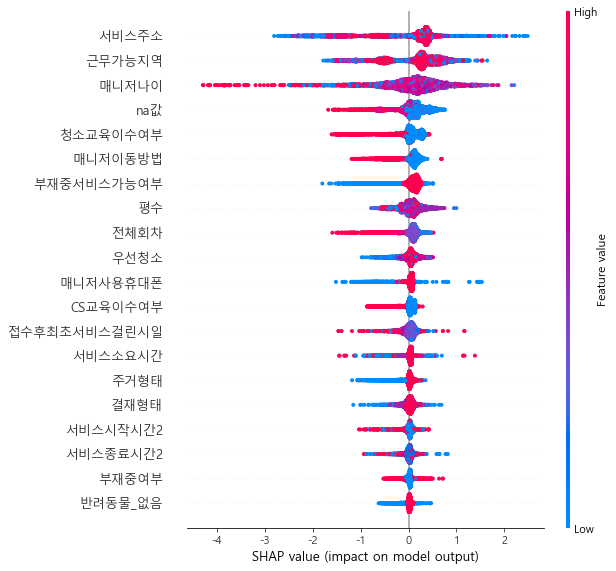

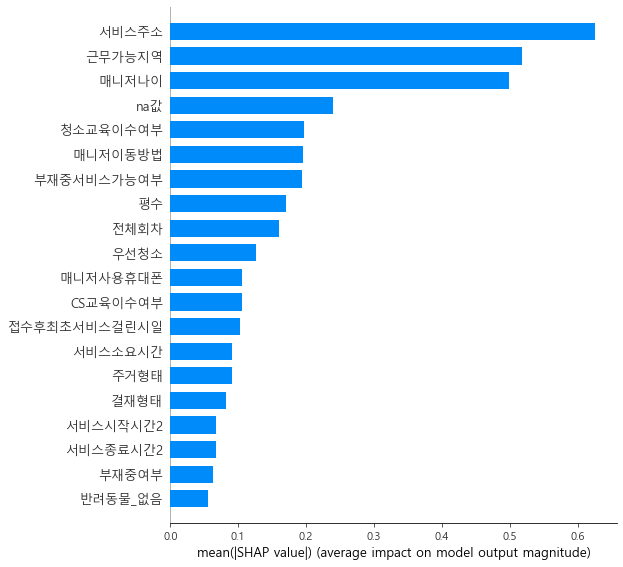

In [196]:
#SHAP로 피쳐임포턴스 확인
import shap


X_importance = ftr_te_imputed

model = CatBoostClassifier(random_state=0).fit(ftr_imputed, target)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)


#model = LGBMRegressor(random_state=0).fit(X_train_scaled, y)
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot
shap.summary_plot(shap_values, X_importance, plot_type='bar')

#shap_sum = np.abs(shap_values).mean(axis=0)
#importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
#importance_df.columns = ['column_name', 'shap_importance']
#importance_df = importance_df.sort_values('shap_importance', ascending=False)
#importance_df

In [194]:
submission

,pred
SEQ,
T54370,0.000674
T47892,0.262507
T56637,0.555486
T45487,0.000900
T41995,0.277941
...,...
T31589,0.081892
T36236,0.037195
T34729,0.490462


In [185]:
cb_pred

array([6.74427189e-04, 2.62506555e-01, 5.55486150e-01, ...,
       4.90462079e-01, 1.46513404e-02, 7.25852894e-01])

### LightGBM

In [91]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype('category')
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype('category')

In [92]:
lgb = LGBMClassifier(random_state=0, max_depth=16, n_estimators=20000, learning_rate=0.01, 
                     boost_from_average=True, is_unbalance=True)

In [93]:
lgb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed.values, target):
    tr_x, val_x = ftr_imputed.values[tr_idx], ftr_imputed.values[val_idx]
    tr_y, val_y = target[tr_idx], target[val_idx]
    lgb.fit(tr_x, tr_y, eval_set=[(tr_x, tr_y), (val_x, val_y)], eval_metric='logloss', early_stopping_rounds=2000, 
             verbose=2000)
    pred = lgb.predict(val_x)
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = lgb.predict(ftr_te_imputed) / 10
    lgb_pred += sub_pred
print(f'\n{lgb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.292114	valid_1's binary_logloss: 0.326654
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.311186	valid_1's binary_logloss: 0.311216
FOLD ROC-AUC = 0.5
Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.284187	valid_1's binary_logloss: 0.33849
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.311471	valid_1's binary_logloss: 0.31183
FOLD ROC-AUC = 0.5
Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.283878	valid_1's binary_logloss: 0.30278
[4000]	training's binary_logloss: 0.181079	valid_1's binary_logloss: 0.221428
[6000]	training's binary_logloss: 0.134908	valid_1's binary_logloss: 0.195425
[8000]	training's binary_logloss: 0.102978	valid_1's binary_logloss: 0.185444
[10000]	training's binary_logloss: 0.0800136	valid_1's binary_logloss: 0.177811
[12000]	

In [80]:
lgb_pred.shape

(4244,)

In [81]:
lgb_pred

array([0., 0., 0., ..., 0., 0., 0.])

## submission

In [82]:
submission['pred'] = (lgb_pred)

In [83]:
submission['pred'] = submission['pred'].apply(lambda x : 1 if x >= 0.5 else 0)

In [84]:
submission['pred'].value_counts()

0    4244
Name: pred, dtype: int64

In [ ]:
submission

In [42]:
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T02974,0
T01495,1
T24344,0
T01825,0
T21915,0
...,...
T02686,0
T06003,0
T23943,0


In [79]:
submission.to_csv('submission/1116_lgb_mm_pyeong.csv')